In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
%matplotlib inline
import librosa
train_audio_path = 'input/train/audio'
filename = '/yes/ffd2ba2f_nohash_0.wav'
samples, sample_rate = librosa.load(str(train_audio_path)+filename)

### Spectrogram

fft를 배웠으니 다시 spectrogram으로 돌아가 봅시다. 우리는 첫번쨰 포스팅에서 spectrogram이 시간축과 주파수 축 변화에 따라 진폭차이를 색상을 통해 보여준다고 했습니다.

Spectrogram을 추출하는 방법을 고민해봅시다.일반적으로 프로세스는 입력신호에 대해서 window function을 통과하여 window size만큼 sampling 된 data를 받아서 Discrete Fourier Transform을 거치게 됩니다. DFT를 거친 신호들은 Frequency와 Amplitude의 영역을 가지는 Spectrum이 됩니다. 이후 이를 90도로 회전시켜서, time domain으로 stack하게 됩니다.

Spectrogram은 Frequency Scale에 대해서 Scaling이 이루어집니다. 주파수 영역에 Scaling을 하는 이유는, 인간의 주파수를 인식하는 방식과 연관이 있습니다. 

일반적으로 사람은, 인접한 주파수를 크게 구별하지 못합니다. 그 이유는 우리의 인지기관이 categorical한 구분을 하기 때문입니다. 때문에 우리는 주파수들의 Bin의 그룹을 만들고 이들을 합하는 방식으로, 주파수 영역에서 얼마만큼의 에너지가 있는지를 찾아볼 것입니다. 일반적으로는 인간이 적은 주파수에 더 풍부한 정보를 사용하기때문에, 주파수가 올라갈수록 필터의 폭이 높아지면서 고주파는 거의 고려를 안하게 됩니다.

따라서 아래 frequency scale은 어떤 방식을 통해 저주파수대 영역을 고려할 것이가에 대한 고민이 남아 있습니다.

### Linear frequency scale

일반적으로 single tone(순음)들의 배음 구조를 파악하기 좋습니다. 
하지만 분포가 저주파수 영역에 기울어져(skewed) 있습니다.

### Mel Scale
멜 스펙트럼은 주파수 단위를 다음 공식에 따라 멜 단위로 바꾼 것을 의미합니다.
<img src='./img/melbank.png' width=70%>

$$
m = 2595 \log_{10}\left(1 + \frac{f}{700}\right)
$$
일반적으로는 mel-scaled bin을 FFT size보다 조금더 작게 만드는게 일반적입니다.

In [2]:
# STFT
S = librosa.core.stft(samples, n_fft=1024, hop_length=512, win_length=1024)
# phase 에 대한 정보를 날린다.
D = np.abs(S)**2

In [10]:
# mel spectrogram (512 --> 40)
mel_basis = librosa.filters.mel(sample_rate, 1024, n_mels=40)
mel_S = np.dot(mel_basis, D)
mel_S.shape

(40, 44)

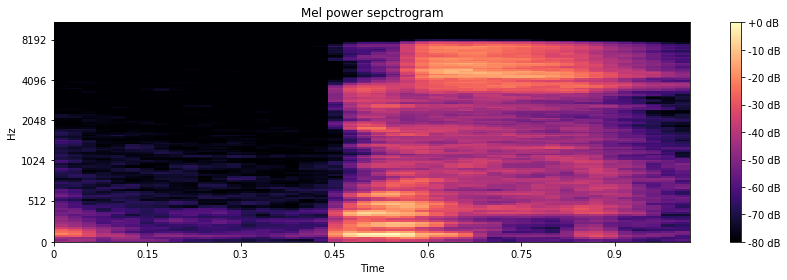

In [7]:
import librosa.display

S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels = 128)
log_S = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(12,4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power sepctrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

### Log compression

$$ 10 * log10(\frac{S}{ref})$$
의 단위로 신호를 스케일링 합니다. 이는 spectrogram을 데시벨 유닛으로 전환해 줍니다.

In [8]:
#log compression
log_mel_S = librosa.power_to_db(mel_S)

In [9]:
log_mel_S.shape

(40, 44)


### Bark scale
귀가 인식하는 주파수의 영역은 대략 $20Hz~2000Hz$로 가정합니다. 하지만 주파수에 대한 사람의 인식은 비선형적입니다. 귀와 뇌의 가청대역을 24개의 대역으로 나눈것을 Bark라고 합니다! Bark scale은 $500Hz$ 이하에서는 $100Hz$의 대역폭을 가지며, $500Hz$ 이상에서는 각 대역의 중심수파수의 대략 20%에 해당하는 대역폭을 가지게 됩니다.

`20, 100, 200, 300, 400, 510, 630, 770, 920, 1080, 1270, 1480, 1720, 2000, 2320, 2700, 3150, 3700, 4400, 5300, 6400, 7700, 9500, 12000, 15500 ( Hz )`

### Equivalent regular bandwidth rate

Critical band 측정을 기반으로 만들어 졌습니다. notched-noise method 입니다.

### Discrete cosine transform (DCT)

DCT는 n개의 데이터를 n개의 코사인 함수의 합으로 표현하여 데이터의 양을 줄이는 방식입니다. 

- 저 주파수에 에너지가 집중되고 고 주파수 영역에 에너지가 감소합니다.

Filter Bank는 모두 Overlapping 되어 있기 때문에 Filter Bank 에너지들 사이에 상관관계가 존재하기 때문이다. DCT는 에너지들 사이에 이러한 상관관계를 분리 해주는 역활을 해줍니다.

하지만 여기서 26개 DCT Coefficient 들 중 12만 남겨야 하는데, 그 이유는 DCT Coefficient 가 많으면, Filter Bank 에너지의 빠른 변화를 나타내게 되고, 이것은 음성인식의 성능을 낮추게 되기 때문이다.

In [10]:
# mfcc (DCT)
mfcc = librosa.feature.mfcc(S=log_mel_S, n_mfcc=13)
mfcc = mfcc.astype(np.float32)    # to save the memory (64 to 32 bits)
mfcc[0]

array([-352.24487, -366.56326, -374.9281 , -390.60297, -385.9468 ,
       -392.3261 , -398.55487, -396.6922 , -395.0417 , -398.3241 ,
       -400.8156 , -399.5283 , -400.10876, -405.3044 , -407.25635,
       -410.77112, -409.39105, -405.62488, -400.28088, -386.88754,
       -256.587  , -184.99794, -167.65366, -155.98474, -151.11472,
       -136.15807, -139.98293, -145.12239, -152.257  , -160.66386,
       -164.44904, -166.04997, -172.92793, -178.01353, -180.90056,
       -187.92828, -179.37764, -190.39357, -217.45445, -235.33223,
       -262.61517, -282.51657, -303.91086, -313.25308], dtype=float32)

(13, 44)


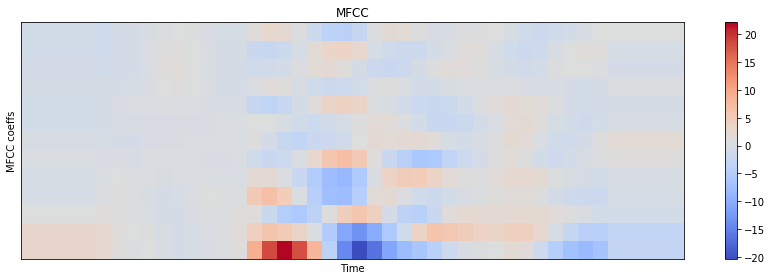

In [11]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)
print(delta2_mfcc.shape)

plt.figure(figsize=(12,4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()